In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:
import pandas as pd

# 1) CSV 로드
df_anime   = pd.read_csv("anilist_anime.csv")
df_genres  = pd.read_csv("anilist_anime_genres.csv")   # anime_id, genre
df_tags    = pd.read_csv("anilist_anime_tags.csv")     # anime_id, tag_name
df_studios = pd.read_csv("anilist_anime_studios.csv")  # anime_id, studio_name, is_main
df_staff   = pd.read_csv("anilist_anime_staff.csv")    # anime_id, staff_name, primary_occupations, role

# 중복 제거 + 정렬 후 "Action|Comedy" 형태로 합치기
genres_agg = (
    df_genres
    .dropna(subset=["genre"])
    .groupby("anime_id")["genre"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"genre": "genre_list"})
)


tags_agg = (
    df_tags
    .dropna(subset=["tag_name"])
    .groupby("anime_id")["tag_name"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"tag_name": "tag_list"})
)

# is_main이 True인 스튜디오만 골라서 main_studio_name 만들기
main_studio_agg = (
    df_studios[df_studios["is_main"] == True]   # bool 컬럼이면 이렇게 필터
    .dropna(subset=["studio_name"])
    .groupby("anime_id")["studio_name"]
    .first()  # 메인 스튜디오 여러 개여도 첫 번째만
    .reset_index()
    .rename(columns={"studio_name": "main_studio_name"})
)

# 전체 스튜디오 이름을 studio_list로 합치기
all_studio_agg = (
    df_studios
    .dropna(subset=["studio_name"])
    .groupby("anime_id")["studio_name"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"studio_name": "studio_list"})
)

# role에 'Director'가 들어가는 스태프만
mask_director = df_staff["role"].fillna("").str.contains("Director", case=False)
df_director = df_staff[mask_director].copy()

directors_agg = (
    df_director
    .dropna(subset=["staff_name"])
    .groupby("anime_id")["staff_name"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"staff_name": "directors"})
)

# df_anime의 PK는 id, 나머지는 anime_id 기준이므로 left_on/right_on 사용
df_eda = df_anime.copy()

# 장르
df_eda = df_eda.merge(genres_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

# 태그
df_eda = df_eda.merge(tags_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

# 스튜디오 (메인 + 전체)
df_eda = df_eda.merge(main_studio_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

df_eda = df_eda.merge(all_studio_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

# 감독 정보
df_eda = df_eda.merge(directors_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

print(df_eda.head())
print(df_eda.columns)


def build_anilist_eda_dataframe(base_path: str = ".") -> pd.DataFrame:
    # 1) CSV 로드
    df_anime   = pd.read_csv(f"{base_path}/anilist_anime.csv")
    df_genres  = pd.read_csv(f"{base_path}/anilist_anime_genres.csv")
    df_tags    = pd.read_csv(f"{base_path}/anilist_anime_tags.csv")
    df_studios = pd.read_csv(f"{base_path}/anilist_anime_studios.csv")
    df_staff   = pd.read_csv(f"{base_path}/anilist_anime_staff.csv")

    # 2) 장르 집계
    genres_agg = (
        df_genres.dropna(subset=["genre"])
        .groupby("anime_id")["genre"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"genre": "genre_list"})
    )

    # 3) 태그 집계
    tags_agg = (
        df_tags.dropna(subset=["tag_name"])
        .groupby("anime_id")["tag_name"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"tag_name": "tag_list"})
    )

    # 4) 스튜디오 집계
    main_studio_agg = (
        df_studios[df_studios["is_main"] == True]
        .dropna(subset=["studio_name"])
        .groupby("anime_id")["studio_name"]
        .first()
        .reset_index()
        .rename(columns={"studio_name": "main_studio_name"})
    )

    all_studio_agg = (
        df_studios
        .dropna(subset=["studio_name"])
        .groupby("anime_id")["studio_name"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"studio_name": "studio_list"})
    )

    # 5) 감독 집계
    mask_director = df_staff["role"].fillna("").str.contains("Director", case=False)
    df_director = df_staff[mask_director].copy()

    directors_agg = (
        df_director
        .dropna(subset=["staff_name"])
        .groupby("anime_id")["staff_name"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"staff_name": "directors"})
    )

    # 6) 병합
    df_eda = df_anime.copy()

    for agg_df in [genres_agg, tags_agg, main_studio_agg, all_studio_agg, directors_agg]:
        df_eda = df_eda.merge(agg_df, left_on="id", right_on="anime_id", how="left")
        df_eda.drop(columns=["anime_id"], inplace=True)

    return df_eda


# 사용 예시
df_eda = build_anilist_eda_dataframe(base_path=".")
print(df_eda.head())


       id                   title_english format    status  season  \
0   16498                 Attack on Titan     TV  FINISHED  SPRING   
1  101922  Demon Slayer: Kimetsu no Yaiba     TV  FINISHED  SPRING   
2    1535                      Death Note     TV  FINISHED    FALL   
3  113415                  JUJUTSU KAISEN     TV  FINISHED    FALL   
4   21459                My Hero Academia     TV  FINISHED  SPRING   

   seasonYear  seasonInt  episodes  duration  averageScore  meanScore  \
0      2013.0      132.0      25.0      24.0          85.0       85.0   
1      2019.0      192.0      26.0      24.0          82.0       82.0   
2      2006.0       64.0      37.0      23.0          84.0       84.0   
3      2020.0      204.0      24.0      24.0          84.0       84.0   
4      2016.0      162.0      13.0      24.0          76.0       76.0   

   popularity  favourites                                   genre_list  \
0      923138       55764                 Action|Drama|Fantasy|Mys

In [4]:
def run_anime_eda(
    df,
    sample_scatter=3000,
    top_n_genres=20,
    top_n_tags=20,
):
    """
    Anime 상관관계 EDA 자동 시각화 함수.
    
    Parameters
    ----------
    df : pd.DataFrame
        id, title_english, format, status, season, seasonYear, seasonInt,
        episodes, duration, averageScore, meanScore, popularity, favourites,
        genre_list, tag_list, main_studio_name, studio_list, directors 포함된 DataFrame
    sample_scatter : int
        산점도 그릴 때 사용할 최대 샘플 수 (성능/시각화용)
    top_n_genres : int
        상관분석에 사용할 상위 장르 개수
    top_n_tags : int
        상관분석에 사용할 상위 태그 개수
    """
    
    # ---------------------------
    # 1. 기본 정보 출력
    # ---------------------------
    print("=== 기본 정보 ===")
    print(df.shape)
    print(df.dtypes)
    print()
    
    # ---------------------------
    # 2. 수치형 컬럼 상관 Heatmap
    # ---------------------------
    numeric_cols = [
        "seasonYear", "seasonInt", "episodes", "duration",
        "averageScore", "meanScore", "popularity", "favourites"
    ]
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    
    print("=== 수치형 컬럼 상관계수 ===")
    corr = df[numeric_cols].corr()
    display(corr)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Numeric Features Correlation Heatmap")
    plt.tight_layout()
    plt.show()
    
    # ---------------------------
    # 3. 주요 산점도 (점수 vs 인기)
    # ---------------------------
    print("\n=== 산점도: Score vs Popularity/Favourites ===")
    
    # 샘플링 (10000개 다 그리면 너무 빽빽할 수 있음)
    if len(df) > sample_scatter:
        df_plot = df.sample(sample_scatter, random_state=42)
    else:
        df_plot = df.copy()
    
    # averageScore vs popularity
    if {"averageScore", "popularity"}.issubset(df.columns):
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=df_plot, x="averageScore", y="popularity", alpha=0.5)
        plt.title("Average Score vs Popularity")
        plt.tight_layout()
        plt.show()
    
    # meanScore vs popularity
    if {"meanScore", "popularity"}.issubset(df.columns):
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=df_plot, x="meanScore", y="popularity", alpha=0.5)
        plt.title("Mean Score vs Popularity")
        plt.tight_layout()
        plt.show()
    
    # episodes vs popularity
    if {"episodes", "popularity"}.issubset(df.columns):
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=df_plot, x="episodes", y="popularity", alpha=0.5)
        plt.title("Episodes vs Popularity")
        plt.tight_layout()
        plt.show()
    
    # duration vs averageScore
    if {"duration", "averageScore"}.issubset(df.columns):
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=df_plot, x="duration", y="averageScore", alpha=0.5)
        plt.title("Duration vs Average Score")
        plt.tight_layout()
        plt.show()
    
    # ---------------------------
    # 4. 범주형 vs 수치형 (Boxplot)
    # ---------------------------
    print("\n=== Boxplot: Season / Format / Studio vs Score ===")
    
    # season vs averageScore
    if {"season", "averageScore"}.issubset(df.columns):
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x="season", y="averageScore")
        plt.title("Season vs Average Score")
        plt.tight_layout()
        plt.show()
    
    # format vs popularity
    if {"format", "popularity"}.issubset(df.columns):
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x="format", y="popularity")
        plt.title("Format vs Popularity")
        plt.tight_layout()
        plt.show()
    
    # 상위 몇 개 스튜디오만
    if {"main_studio_name", "averageScore"}.issubset(df.columns):
        top_studios = df["main_studio_name"].value_counts().head(10).index
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=df[df["main_studio_name"].isin(top_studios)],
            x="main_studio_name",
            y="averageScore"
        )
        plt.xticks(rotation=45, ha="right")
        plt.title("Average Score by Main Studio (Top 10)")
        plt.tight_layout()
        plt.show()
    
    # ---------------------------
    # 5. 장르 One-hot vs Score/Popularity 상관
    # ---------------------------
    if "genre_list" in df.columns:
        print("\n=== Genre vs Score/Popularity Correlation ===")
        # 장르 더미화
        df_genre = df["genre_list"].str.get_dummies(sep="|")
        
        # 너무 많은 장르는 상위 N개만
        top_genres = df_genre.sum().sort_values(ascending=False).head(top_n_genres).index
        df_genre_top = df_genre[top_genres]
        
        # 점수/인기도 컬럼과 join
        target_cols = [c for c in ["averageScore", "popularity", "favourites"] if c in df.columns]
        genre_corr = df_genre_top.join(df[target_cols]).corr()
        
        # 장르 vs 타겟만 추출
        heatmap_data = genre_corr.loc[top_genres, target_cols]
        display(heatmap_data)
        
        plt.figure(figsize=(10, max(6, len(top_genres) * 0.4)))
        sns.heatmap(heatmap_data, annot=False, cmap="coolwarm")
        plt.title("Genre vs Score / Popularity / Favourites")
        plt.tight_layout()
        plt.show()
    
    # ---------------------------
    # 6. 태그 One-hot vs Score/Popularity 상관
    # ---------------------------
    if "tag_list" in df.columns:
        print("\n=== Tag vs Score/Popularity Correlation ===")
        df_tag = df["tag_list"].str.get_dummies(sep="|")
        
        top_tags = df_tag.sum().sort_values(ascending=False).head(top_n_tags).index
        df_tag_top = df_tag[top_tags]
        
        target_cols = [c for c in ["averageScore", "popularity", "favourites"] if c in df.columns]
        tag_corr = df_tag_top.join(df[target_cols]).corr()
        
        heatmap_data = tag_corr.loc[top_tags, target_cols]
        display(heatmap_data)
        
        plt.figure(figsize=(10, max(6, len(top_tags) * 0.4)))
        sns.heatmap(heatmap_data, annot=False, cmap="coolwarm")
        plt.title("Tag vs Score / Popularity / Favourites")
        plt.tight_layout()
        plt.show()
    
    print("\n✅ EDA 완료!")


# AniList Top 10,000 Anime – 상관관계 EDA


## 2. 기본 구조 확인 (info / head / 결측치)


In [7]:
display(df_eda.head())
print(df_eda.info())

df_eda.isna().mean().sort_values(ascending=False)


,id,title_english,format,status,season,seasonYear,seasonInt,episodes,duration,averageScore,meanScore,popularity,favourites,genre_list,tag_list,main_studio_name,studio_list,directors
0,16498,Attack on Titan,TV,FINISHED,SPRING,2013.0,132.0,25.0,24.0,85.0,85.0,923138,55764,Action|Drama|Fantasy|Mystery,Adoption|Amnesia|CGI|Cannibalism|Coming of Age...,WIT STUDIO,Dentsu|Kodansha|Mainichi Broadcasting System|P...,Mike McFarland|Sayo Yamamoto|Tetsurou Araki
1,101922,Demon Slayer: Kimetsu no Yaiba,TV,FINISHED,SPRING,2019.0,192.0,26.0,24.0,82.0,82.0,876899,42063,Action|Adventure|Drama|Fantasy|Supernatural,Animals|Body Horror|CGI|Chibi|Curses|Demons|Fo...,ufotable,Aniplex|Aniplex of America|Shueisha|ufotable,Cassius Romero|Haruo Sotozaki|Steve Staley
2,1535,Death Note,TV,FINISHED,FALL,2006.0,64.0,37.0,23.0,84.0,84.0,840513,44157,Mystery|Psychological|Supernatural|Thriller,Achronological Order|Acting|Amnesia|Anti-Hero|...,MADHOUSE,Ashi Productions|Konami|MADHOUSE|Nippon Televi...,Takahiro Kagami|Takehiro Hamatsu|Tetsurou Arak...
3,113415,JUJUTSU KAISEN,TV,FINISHED,FALL,2020.0,204.0,24.0,24.0,84.0,84.0,831521,49300,Action|Drama|Supernatural,Anthropomorphism|Baseball|Boarding School|Body...,MAPPA,MAPPA|Mainichi Broadcasting System|Shueisha|Su...,Hironori Tanaka|Michael Sorich|Patricia Aceved...
4,21459,My Hero Academia,TV,FINISHED,SPRING,2016.0,162.0,13.0,24.0,76.0,76.0,777648,20698,Action|Adventure|Comedy,Bullying|Coming of Age|Cultivation|Ensemble Ca...,bones,Dentsu|Mainichi Broadcasting System|Movic|Toho...,Colleen Clinkenbeard|Toshihiro Kawamoto|Yoshih...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   title_english     6836 non-null   object 
 2   format            10000 non-null  object 
 3   status            10000 non-null  object 
 4   season            9127 non-null   object 
 5   seasonYear        9127 non-null   float64
 6   seasonInt         9146 non-null   float64
 7   episodes          9719 non-null   float64
 8   duration          9670 non-null   float64
 9   averageScore      9676 non-null   float64
 10  meanScore         9701 non-null   float64
 11  popularity        10000 non-null  int64  
 12  favourites        10000 non-null  int64  
 13  genre_list        9907 non-null   object 
 14  tag_list          9797 non-null   object 
 15  main_studio_name  8215 non-null   object 
 16  studio_list       9551 non-null   object 

title_english       0.3164
main_studio_name    0.1785
directors           0.1548
seasonYear          0.0873
season              0.0873
seasonInt           0.0854
studio_list         0.0449
duration            0.0330
averageScore        0.0324
meanScore           0.0299
episodes            0.0281
tag_list            0.0203
genre_list          0.0093
id                  0.0000
status              0.0000
format              0.0000
favourites          0.0000
popularity          0.0000
dtype: float64

## 3. Numeric Features 상관관계 Heatmap
- seasonYear, seasonInt, episodes, duration
- averageScore, meanScore, popularity, favourites


,seasonYear,seasonInt,episodes,duration,averageScore,meanScore,popularity,favourites
seasonYear,1.000000,-0.630319,-0.148712,-0.135867,0.164506,0.126462,0.178199,0.094504
seasonInt,-0.630319,1.000000,0.084533,0.144109,-0.092977,-0.054317,-0.111522,-0.043556
episodes,-0.148712,0.084533,1.000000,-0.143827,0.088954,0.107051,0.073135,0.097267
duration,-0.135867,0.144109,-0.143827,1.000000,0.229619,0.234688,0.015712,0.014472
averageScore,0.164506,-0.092977,0.088954,0.229619,1.000000,0.986311,0.399425,0.329466
meanScore,0.126462,-0.054317,0.107051,0.234688,0.986311,1.000000,0.357116,0.305307
popularity,0.178199,-0.111522,0.073135,0.015712,0.399425,0.357116,1.000000,0.855516
favourites,0.094504,-0.043556,0.097267,0.014472,0.329466,0.305307,0.855516,1.000000


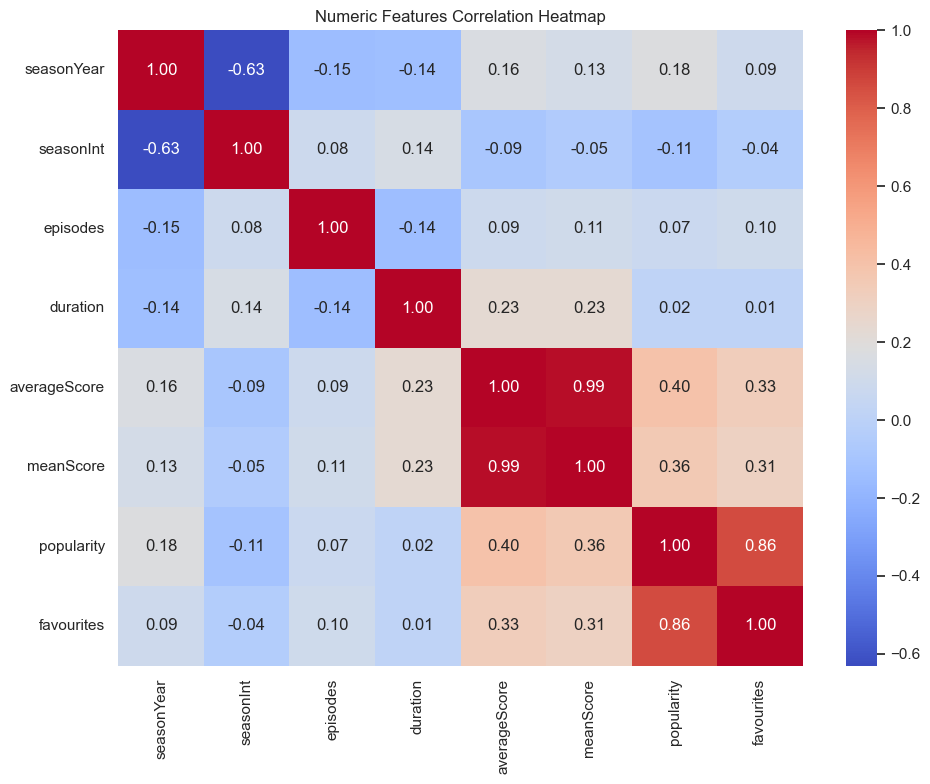

In [6]:
numeric_cols = [
    "seasonYear", "seasonInt", "episodes", "duration",
    "averageScore", "meanScore", "popularity", "favourites"
]

corr = df_eda[numeric_cols].corr()
display(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Features Correlation Heatmap")
plt.tight_layout()
plt.show()


## 4. 주요 관계 산점도 (Score vs Popularity 등)


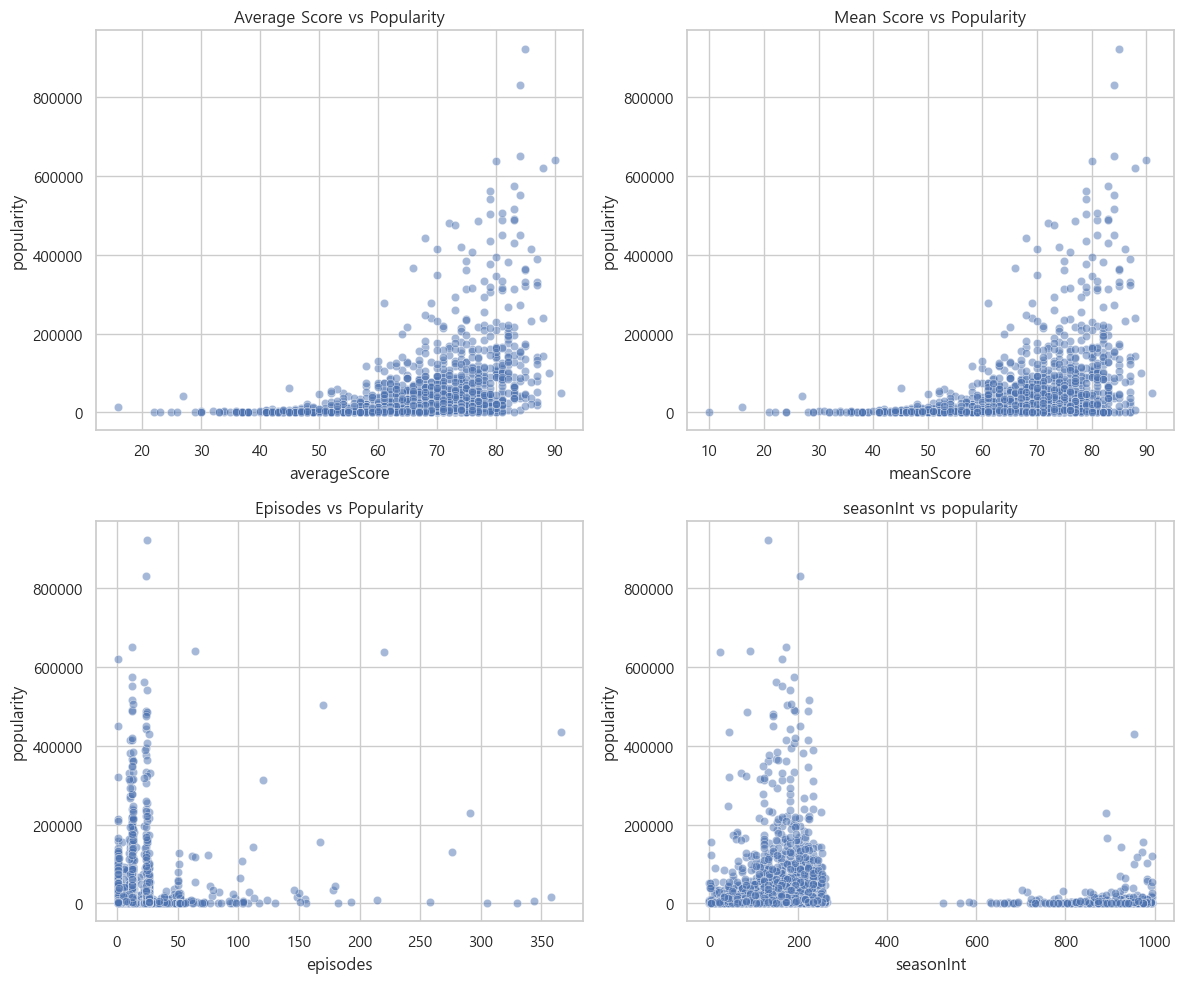

In [33]:
# 성능/시각화를 위해 샘플링
if len(df_eda) > 3000:
    df_eda_plot = df_eda.sample(3000, random_state=42)
else:
    df_eda_plot = df_eda.copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(data=df_eda_plot, x="averageScore", y="popularity", alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title("Average Score vs Popularity")

sns.scatterplot(data=df_eda_plot, x="meanScore", y="popularity", alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title("Mean Score vs Popularity")

sns.scatterplot(data=df_eda_plot, x="episodes", y="popularity", alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title("Episodes vs Popularity")

sns.scatterplot(data=df_eda_plot, x="seasonInt", y="popularity", alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title("seasonInt vs popularity")

plt.tight_layout()
plt.show()


## 5. 범주형 vs 수치형
- Season vs Score
- Format vs Popularity
- Main Studio vs Score


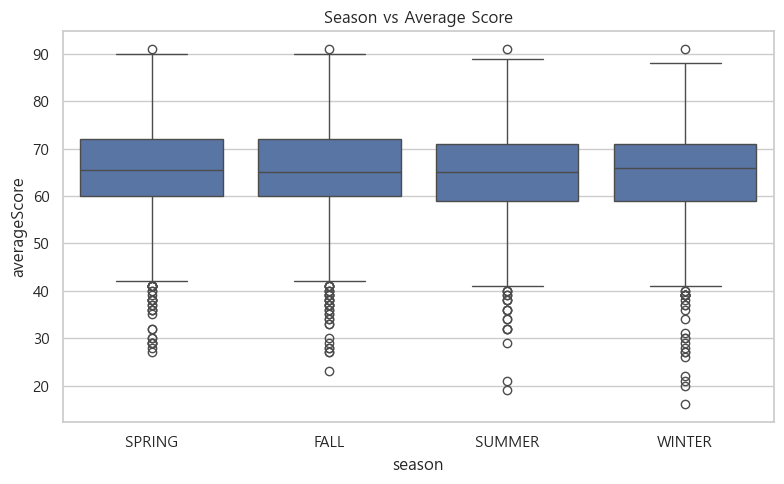

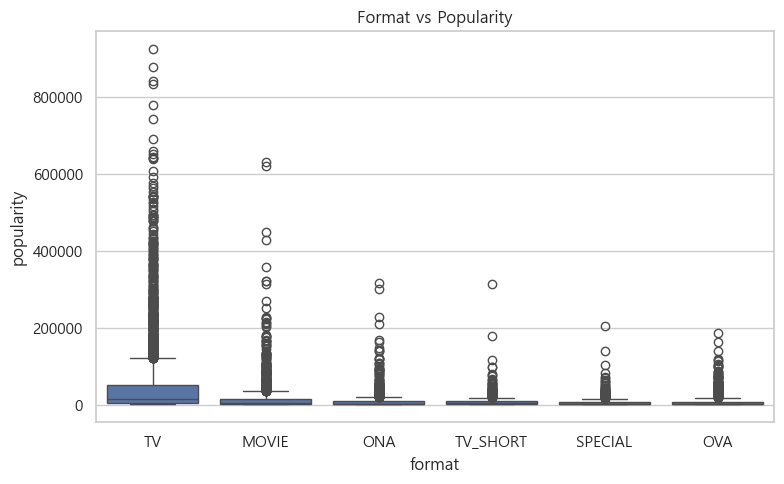

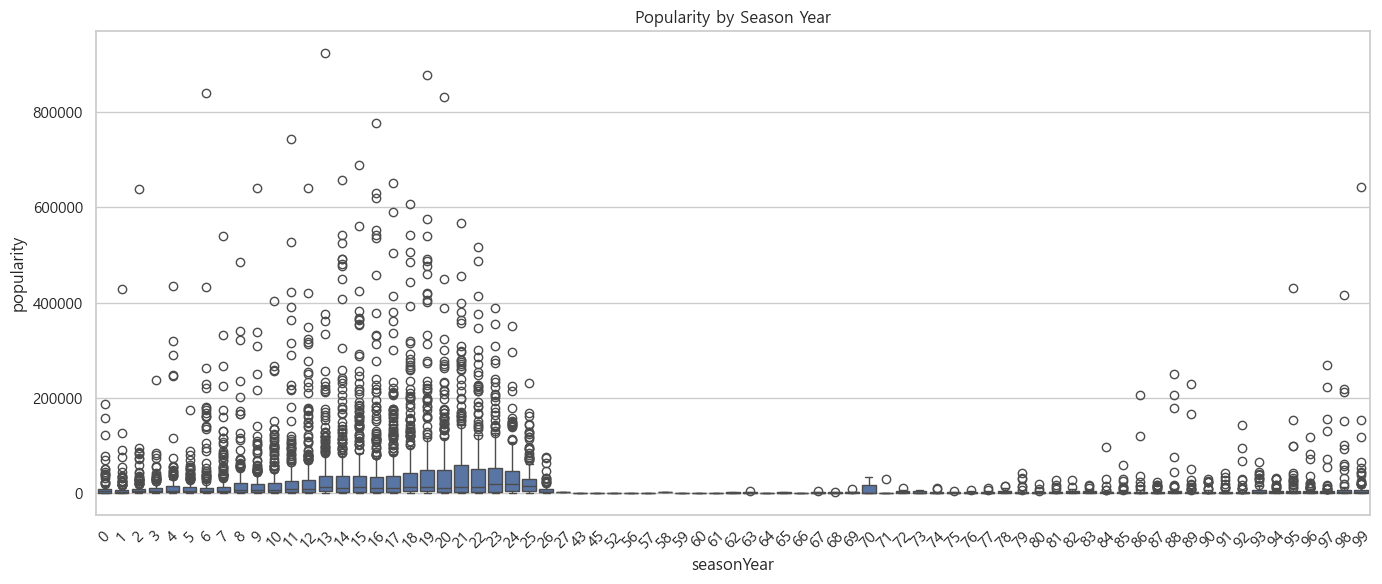

In [44]:
# Season vs Score
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_eda, x="season", y="averageScore")
plt.title("Season vs Average Score")
plt.tight_layout()
plt.show()

# Format vs Popularity
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_eda, x="format", y="popularity")
plt.title("Format vs Popularity")
plt.tight_layout()
plt.show()


# seasonInt vs popularity
# NaN 제거된 임시 df 생성
df_tmp = df_eda.dropna(subset=["seasonInt"]).copy()

# seasonInt를 year로 변환 (ex: 20134 → 2013)
df_tmp["seasonYear"] = (df_tmp["seasonInt"].astype(int) // 10)

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_tmp, x="seasonYear", y="popularity")
plt.xticks(rotation=45)
plt.title("Popularity by Season Year")
plt.tight_layout()
plt.show()



## 6. Genre One-hot vs Score / Popularity
- genre_list → 더미화
- 상위 N개 장르만 사용


,averageScore,popularity,favourites
Comedy,0.039117,0.009445,-0.013226
Action,0.087965,0.109790,0.071000
Fantasy,0.071372,0.068903,0.045272
Drama,0.218305,0.158480,0.149378
Adventure,0.061358,0.036749,0.040419
Sci-Fi,-0.029367,-0.042678,-0.028258
Romance,0.063479,0.089771,0.037836
Slice of Life,0.156817,0.057318,0.034451
Supernatural,0.097489,0.147451,0.092018
Ecchi,-0.124487,0.034321,-0.012592


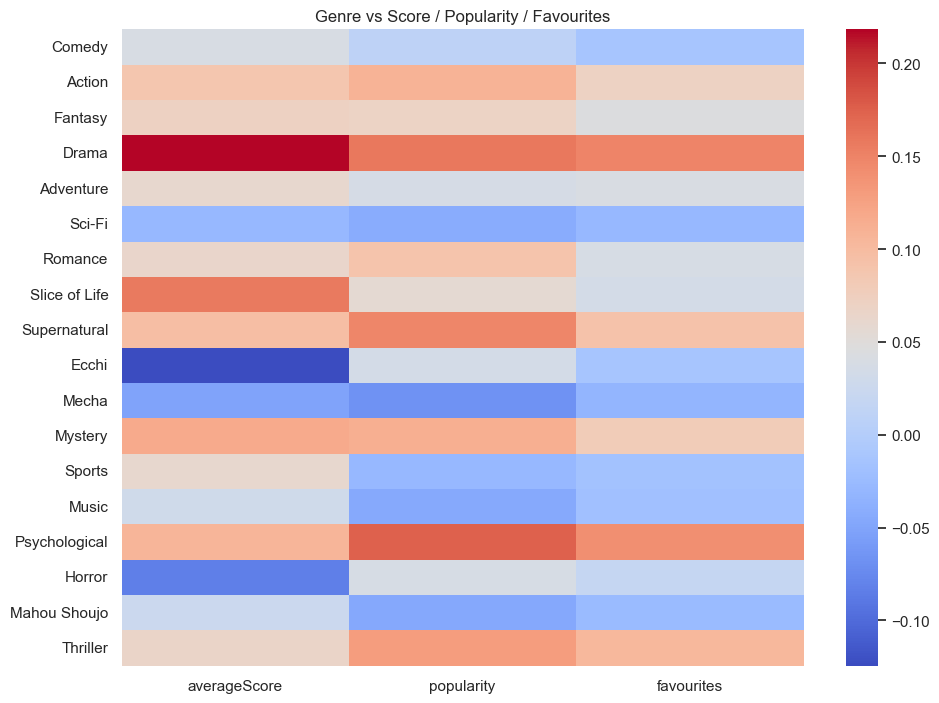

In [12]:
df_eda_genre = df_eda["genre_list"].str.get_dummies(sep="|")

# 상위 N개만
top_n_genres = 20
top_genres = df_eda_genre.sum().sort_values(ascending=False).head(top_n_genres).index
df_eda_genre_top = df_eda_genre[top_genres]

target_cols = [c for c in ["averageScore", "popularity", "favourites"] if c in df_eda.columns]
genre_corr = df_eda_genre_top.join(df_eda[target_cols]).corr()

heatmap_data = genre_corr.loc[top_genres, target_cols]
display(heatmap_data)

plt.figure(figsize=(10, max(6, len(top_genres) * 0.4)))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm")
plt.title("Genre vs Score / Popularity / Favourites")
plt.tight_layout()
plt.show()


## 7. Tag One-hot vs Score / Popularity


,averageScore,popularity,favourites
Male Protagonist,0.257336,0.284612,0.183379
Female Protagonist,0.112953,0.070722,0.040076
School,0.120715,0.149500,0.080655
Primarily Female Cast,0.035830,0.031591,-0.000979
Shounen,0.208843,0.175179,0.125637
Heterosexual,0.178737,0.262427,0.172381
Magic,0.060944,0.072103,0.033706
Ensemble Cast,0.236695,0.221612,0.172838
Tragedy,0.213526,0.260167,0.221916
Primarily Adult Cast,0.155008,0.114569,0.094225


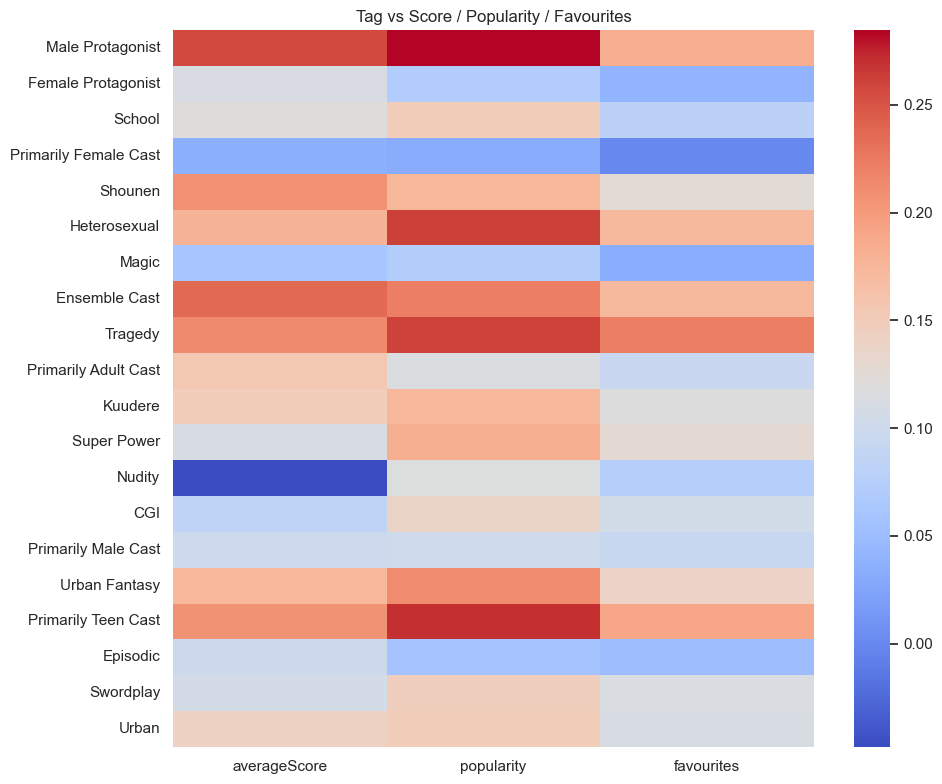

In [13]:
df_eda_tag = df_eda["tag_list"].str.get_dummies(sep="|")

top_n_tags = 20
top_tags = df_eda_tag.sum().sort_values(ascending=False).head(top_n_tags).index
df_tag_top = df_eda_tag[top_tags]

target_cols = [c for c in ["averageScore", "popularity", "favourites"] if c in df_eda.columns]
tag_corr = df_tag_top.join(df_eda[target_cols]).corr()

heatmap_data = tag_corr.loc[top_tags, target_cols]
display(heatmap_data)

plt.figure(figsize=(10, max(6, len(top_tags) * 0.4)))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm")
plt.title("Tag vs Score / Popularity / Favourites")
plt.tight_layout()
plt.show()


In [16]:
def get_top(df_eda, sort_by="popularity", top_n=100, ascending=False):
    """
    df에서 특정 컬럼 기준 Top N 값을 반환하는 함수.
    
    sort_by : 인기 / 점수 / 좋아요 등 기준 컬럼
    top_n   : 상위 몇 개를 볼지
    ascending : 작은 값이 좋은 경우 True
    """
    result = (
        df_eda.sort_values(sort_by, ascending=ascending)
          .head(top_n)
          .reset_index(drop=True)
    )
    return result


In [17]:
top100_pop = get_top(df_eda, sort_by="popularity", top_n=100)
display(top100_pop)


,id,title_english,format,status,season,seasonYear,seasonInt,episodes,duration,averageScore,meanScore,popularity,favourites,genre_list,tag_list,main_studio_name,studio_list,directors
0,16498,Attack on Titan,TV,FINISHED,SPRING,2013.0,132.0,25.0,24.0,85.0,85.0,923138,55764,Action|Drama|Fantasy|Mystery,Adoption|Amnesia|CGI|Cannibalism|Coming of Age...,WIT STUDIO,Dentsu|Kodansha|Mainichi Broadcasting System|P...,Mike McFarland|Sayo Yamamoto|Tetsurou Araki
1,101922,Demon Slayer: Kimetsu no Yaiba,TV,FINISHED,SPRING,2019.0,192.0,26.0,24.0,82.0,82.0,876899,42063,Action|Adventure|Drama|Fantasy|Supernatural,Animals|Body Horror|CGI|Chibi|Curses|Demons|Fo...,ufotable,Aniplex|Aniplex of America|Shueisha|ufotable,Cassius Romero|Haruo Sotozaki|Steve Staley
2,1535,Death Note,TV,FINISHED,FALL,2006.0,64.0,37.0,23.0,84.0,84.0,840513,44157,Mystery|Psychological|Supernatural|Thriller,Achronological Order|Acting|Amnesia|Anti-Hero|...,MADHOUSE,Ashi Productions|Konami|MADHOUSE|Nippon Televi...,Takahiro Kagami|Takehiro Hamatsu|Tetsurou Arak...
3,113415,JUJUTSU KAISEN,TV,FINISHED,FALL,2020.0,204.0,24.0,24.0,84.0,84.0,831521,49300,Action|Drama|Supernatural,Anthropomorphism|Baseball|Boarding School|Body...,MAPPA,MAPPA|Mainichi Broadcasting System|Shueisha|Su...,Hironori Tanaka|Michael Sorich|Patricia Aceved...
4,21459,My Hero Academia,TV,FINISHED,SPRING,2016.0,162.0,13.0,24.0,76.0,76.0,777648,20698,Action|Adventure|Comedy,Bullying|Coming of Age|Cultivation|Ensemble Ca...,bones,Dentsu|Mainichi Broadcasting System|Movic|Toho...,Colleen Clinkenbeard|Toshihiro Kawamoto|Yoshih...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2001,Gurren Lagann,TV,FINISHED,SPRING,2007.0,72.0,27.0,24.0,85.0,85.0,331781,22676,Action|Comedy|Drama|Mecha|Romance|Sci-Fi,Aliens|Alternate Universe|Animals|Anthropomorp...,Gainax,Aniplex|Aniplex of America|Bandai|Bandai Enter...,Hiroyuki Imaishi|Osamu Kobayashi|Shin Itagaki|...
96,21698,HAIKYU!! 3rd Season,TV,FINISHED,FALL,2016.0,164.0,10.0,25.0,87.0,87.0,330116,10646,Comedy|Drama|Sports,Coming of Age|Ensemble Cast|Male Protagonist|P...,Production I.G,Production I.G|Sentai Filmworks,Hiromi Kikuta|Kyle Jones|Patrizio Prata|Susumu...
97,108632,Re:ZERO -Starting Life in Another World- Season 2,TV,FINISHED,SUMMER,2020.0,203.0,13.0,26.0,83.0,83.0,324540,9687,Action|Adventure|Drama|Fantasy|Psychological|T...,Age Gap|Alternate Universe|Assassins|Body Horr...,WHITE FOX,AT-X|Hakuhodo DY Music & Pictures|KADOKAWA|Kad...,Jin Aketagawa|Kazuhiro Oota|Kenichi Kawamura|K...
98,13601,PSYCHO-PASS,TV,FINISHED,FALL,2012.0,124.0,22.0,23.0,81.0,81.0,323720,11460,Action|Psychological|Sci-Fi|Thriller,Anti-Hero|Artificial Intelligence|Augmented Re...,Production I.G,Dentsu|Fuji TV|Funimation|KYORAKU|Nitroplus|Pr...,Fabrizio Mazzotta|Itsurou Kawasaki|Masakazu Sa...


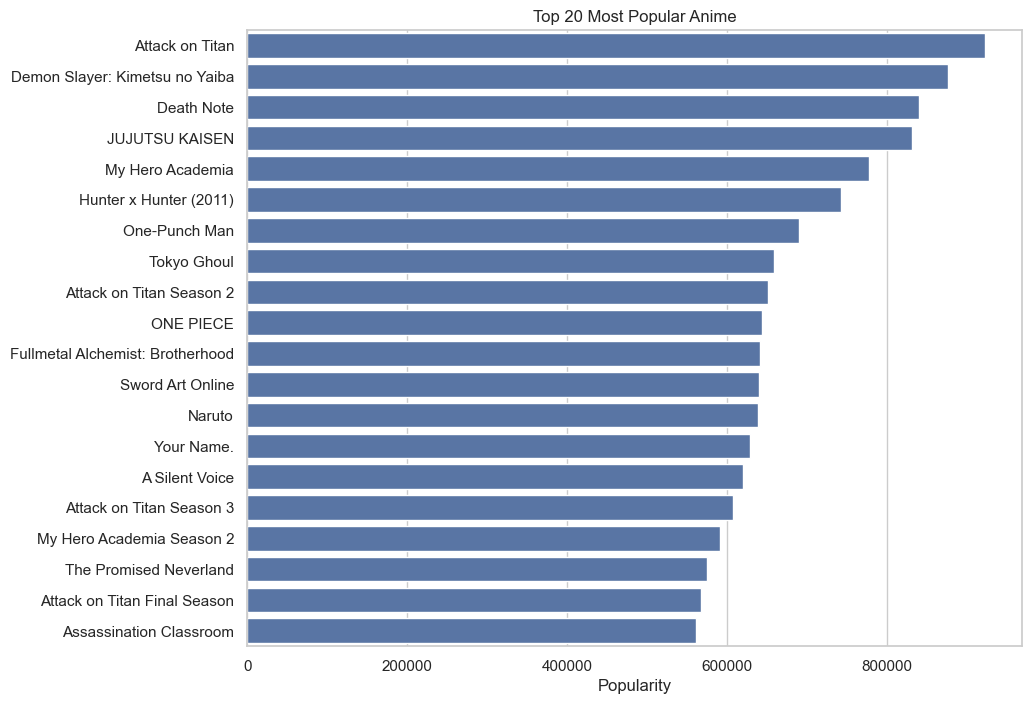

In [18]:
top20 = df_eda.sort_values("popularity", ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=top20, y="title_english", x="popularity")
plt.title("Top 20 Most Popular Anime")
plt.xlabel("Popularity")
plt.ylabel("")
plt.show()


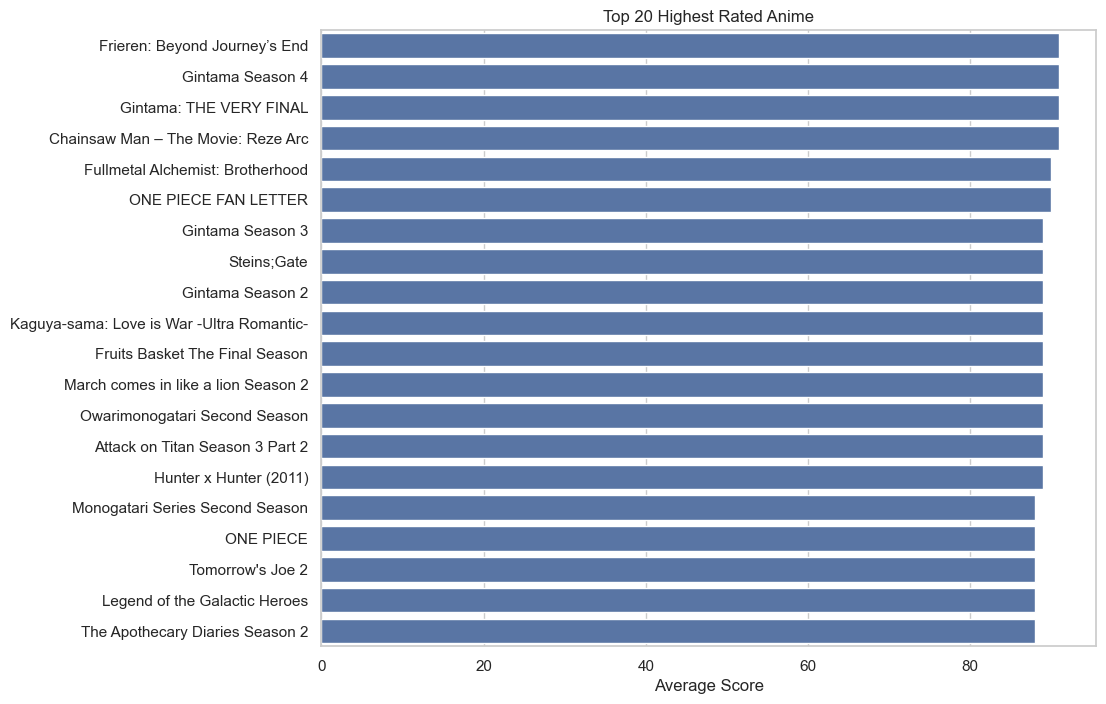

In [19]:
top20_score = df_eda.sort_values("averageScore", ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=top20_score, y="title_english", x="averageScore")
plt.title("Top 20 Highest Rated Anime")
plt.xlabel("Average Score")
plt.ylabel("")
plt.show()


In [20]:
# 1) 인기 Rank (1위가 가장 작음)
df_eda["pop_rank"] = df_eda["popularity"].rank(method="min", ascending=False)

# 2) 점수 Rank
df_eda["score_rank"] = df_eda["averageScore"].rank(method="min", ascending=False)

# 3) 종합 점수 = 두 랭킹의 합
df_eda["total_rank_score"] = df_eda["pop_rank"] + df_eda["score_rank"]

# 4) 종합 상승 Top 10
top10_combined = df_eda.sort_values("total_rank_score").head(10)
display(top10_combined[["title_english", "popularity", "averageScore", "pop_rank", "score_rank", "total_rank_score"]])


,title_english,popularity,averageScore,pop_rank,score_rank,total_rank_score
5,Hunter x Hunter (2011),742982,89.0,6.0,7.0,13.0
10,Fullmetal Alchemist: Brotherhood,641435,90.0,11.0,5.0,16.0
9,ONE PIECE,643138,88.0,10.0,16.0,26.0
14,A Silent Voice,620257,88.0,15.0,16.0,31.0
25,Attack on Titan Season 3 Part 2,540259,89.0,26.0,7.0,33.0
27,Steins;Gate,527039,89.0,28.0,7.0,35.0
18,Attack on Titan Final Season,567298,86.0,19.0,50.0,69.0
42,Vinland Saga,460952,87.0,43.0,27.0,70.0
0,Attack on Titan,923138,85.0,1.0,74.0,75.0
83,Frieren: Beyond Journey’s End,355539,91.0,84.0,1.0,85.0


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\4032713074.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


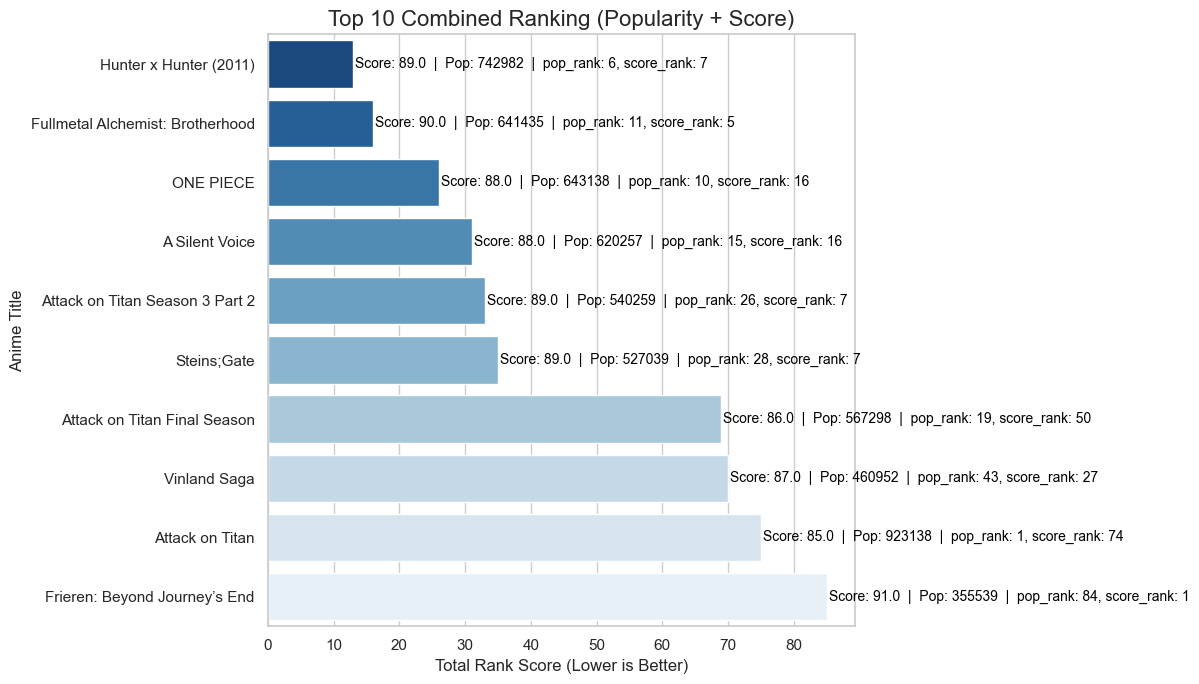

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비 (정렬)
plot_df_eda = top10_combined.sort_values("total_rank_score")

plt.figure(figsize=(12, 7))
sns.barplot(
    data=plot_df_eda,
    x="total_rank_score",
    y="title_english",
    palette="Blues_r"
)

plt.title("Top 10 Combined Ranking (Popularity + Score)", fontsize=16)
plt.xlabel("Total Rank Score (Lower is Better)", fontsize=12)
plt.ylabel("Anime Title", fontsize=12)

# ---- 막대 내부에 상세 정보 annotate ----
for i, row in plot_df_eda.iterrows():
    text = (
        f"Score: {row['averageScore']}  |  "
        f"Pop: {row['popularity']}  |  "
        f"pop_rank: {int(row['pop_rank'])}, score_rank: {int(row['score_rank'])}"
    )
    plt.text(
        row["total_rank_score"] + 0.3,    # X 좌표 (막대 오른쪽)
        plot_df_eda.index.get_loc(i),         # Y 좌표
        text,
        va="center",
        fontsize=10,
        color="black"
    )

plt.tight_layout()
plt.show()


In [22]:
from IPython.display import display

display(
    plot_df_eda[[
        "title_english",
        "averageScore",
        "popularity",
        "pop_rank",
        "score_rank",
        "total_rank_score"
    ]].style.format({
        "averageScore": "{:.0f}",
        "popularity": "{:,}",
        "pop_rank": "{:.0f}",
        "score_rank": "{:.0f}",
        "total_rank_score": "{:.0f}",
    }).set_properties(**{"text-align": "center"})
)


,title_english,averageScore,popularity,pop_rank,score_rank,total_rank_score
5,Hunter x Hunter (2011),89,"742,982",6,7,13
10,Fullmetal Alchemist: Brotherhood,90,"641,435",11,5,16
9,ONE PIECE,88,"643,138",10,16,26
14,A Silent Voice,88,"620,257",15,16,31
25,Attack on Titan Season 3 Part 2,89,"540,259",26,7,33
27,Steins;Gate,89,"527,039",28,7,35
18,Attack on Titan Final Season,86,"567,298",19,50,69
42,Vinland Saga,87,"460,952",43,27,70
0,Attack on Titan,85,"923,138",1,74,75
83,Frieren: Beyond Journey’s End,91,"355,539",84,1,85


In [25]:
# 스튜디오별 집계
studio_rank = (
    df_eda
    .groupby("main_studio_name")
    .agg(
        n_titles=("id", "count"),
        mean_total_rank=("total_rank_score", "mean"),
        median_total_rank=("total_rank_score", "median"),
        best_total_rank=("total_rank_score", "min"),
    )
    .reset_index()
)

# 최소 작품 수 기준 (예: 10편 이상 만든 스튜디오만 랭킹에 넣기)
min_titles = 10
studio_rank_filtered = studio_rank[studio_rank["n_titles"] >= min_titles]

# 종합 순위: 평균 점수 우선, 그 다음 best_total_rank 보조정렬
studio_rank_filtered = studio_rank_filtered.sort_values(
    ["mean_total_rank", "best_total_rank"],
    ascending=[True, True]
)

# 상위 10개 스튜디오
top10_studios = studio_rank_filtered.head(10).reset_index(drop=True)

display(top10_studios)


,main_studio_name,n_titles,mean_total_rank,median_total_rank,best_total_rank
0,Shuka,18,3410.941176,3485.0,1253.0
1,Science SARU,20,4285.294118,2891.0,235.0
2,CloverWorks,55,4737.547170,3188.0,180.0
3,CygamesPictures,15,4820.000000,3821.0,946.0
4,WHITE FOX,40,4940.794872,2774.0,35.0
5,MAPPA,82,4985.807692,4000.0,69.0
6,Manglobe,22,5023.363636,4940.0,281.0
7,Kyoto Animation,118,5061.460870,3865.0,31.0
8,P.A.WORKS,53,5076.820000,3918.0,663.0
9,TROYCA,19,5091.687500,4515.5,1126.0


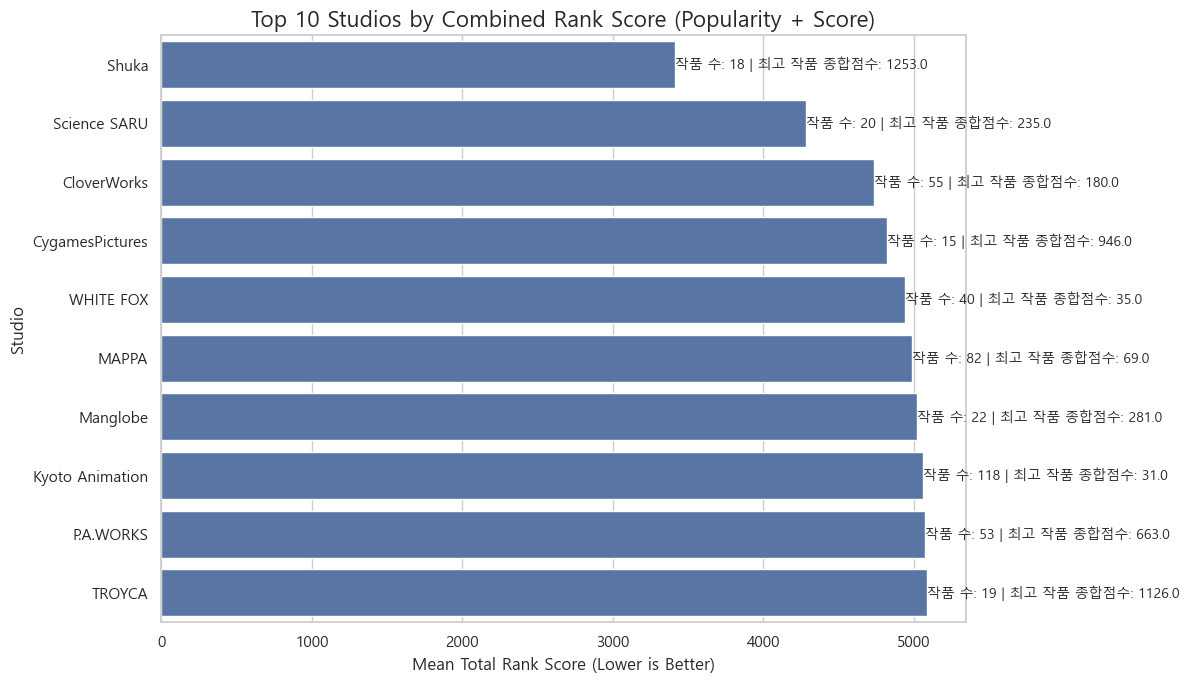

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib

plt.rc('font', family='Malgun Gothic')  # or 'MalgunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


plot_studios = top10_studios.copy()
plot_studios = plot_studios.sort_values("mean_total_rank")  # 낮은 점수 위로

plt.figure(figsize=(12, 7))
sns.barplot(
    data=plot_studios,
    x="mean_total_rank",
    y="main_studio_name",
)

plt.title("Top 10 Studios by Combined Rank Score (Popularity + Score)", fontsize=16)
plt.xlabel("Mean Total Rank Score (Lower is Better)", fontsize=12)
plt.ylabel("Studio", fontsize=12)

# 막대 옆에 작품 수 / best score 라벨
for i, row in plot_studios.iterrows():
    text = (
        f"작품 수: {row['n_titles']} | "
        f"최고 작품 종합점수: {row['best_total_rank']:.1f}"
    )
    plt.text(
        row["mean_total_rank"] + 0.3,          # x 위치 (막대 오른쪽)
        plot_studios.index.get_loc(i),         # y 위치
        text,
        va="center",
        fontsize=10,
    )

plt.tight_layout()
plt.show()


In [31]:
# 0) 유효한 데이터만 사용 (스튜디오명, total_rank_score 둘 다 존재하는 행만)
df_valid = df_eda.dropna(subset=["main_studio_name", "total_rank_score"]).copy()

# 1) 각 스튜디오별로 total_rank_score가 가장 낮은(=베스트) 작품 인덱스
idx = (
    df_valid.groupby("main_studio_name")["total_rank_score"]
            .idxmin()
)

# 2) 이 인덱스들에 해당하는 행만 추출
best_titles_per_studio = df_valid.loc[idx, [
    "main_studio_name",
    "title_english",
    "total_rank_score",
    "popularity",
    "averageScore"
]].reset_index(drop=True)


best_titles_top10_studios = best_titles_per_studio[
    best_titles_per_studio["main_studio_name"].isin(top10_studios["main_studio_name"])
].sort_values("total_rank_score")

display(best_titles_top10_studios)


,main_studio_name,title_english,total_rank_score,popularity,averageScore
236,Kyoto Animation,A Silent Voice,31.0,620257,88.0
545,WHITE FOX,Steins;Gate,35.0,527039,89.0
261,MAPPA,Attack on Titan Final Season,69.0,567298,86.0
95,CloverWorks,The Promised Neverland,180.0,574760,83.0
384,Science SARU,DAN DA DAN,235.0,296153,84.0
269,Manglobe,Samurai Champloo,281.0,249178,84.0
313,P.A.WORKS,Maquia: When the Promised Flower Blooms,663.0,130314,82.0
105,CygamesPictures,The Summer Hikaru Died,946.0,95110,81.0
492,TROYCA,Bloom Into You,1126.0,124220,78.0
399,Shuka,Durarara!! X2,1253.0,103180,78.0


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\4250343553.py:35: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\4250343553.py:35: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\Playdata\miniconda3\envs\ai_basic_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Playdata\miniconda3\envs\ai_basic_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


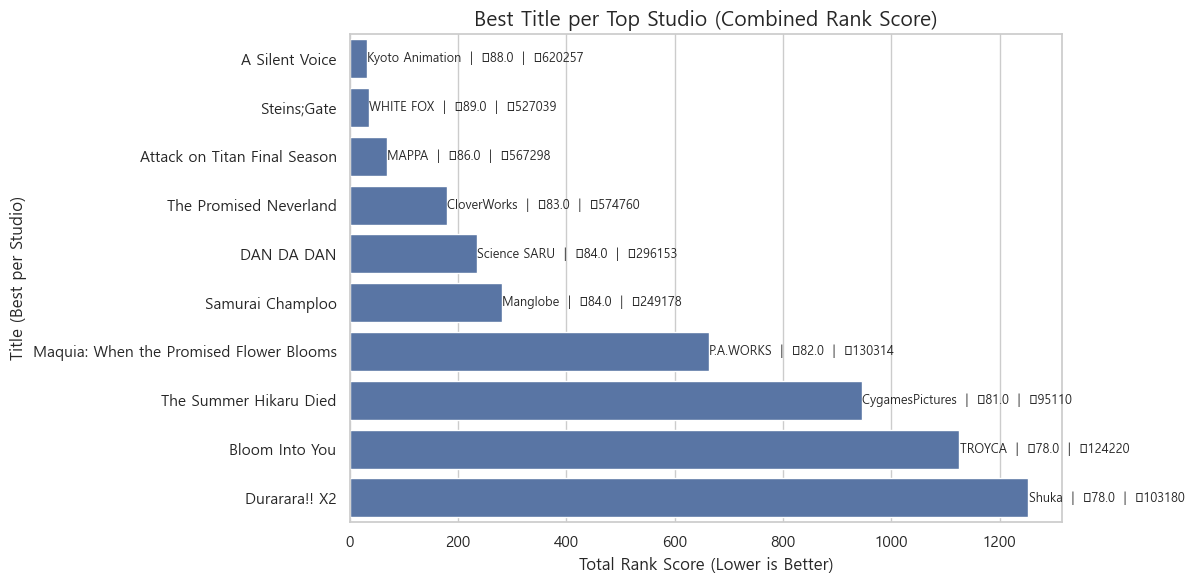

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = best_titles_top10_studios.copy()

# 점수 낮을수록 좋은 거라 오름차순 정렬
plot_df = plot_df.sort_values("total_rank_score", ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df,
    x="total_rank_score",
    y="title_english",
)

plt.title("Best Title per Top Studio (Combined Rank Score)", fontsize=15)
plt.xlabel("Total Rank Score (Lower is Better)")
plt.ylabel("Title (Best per Studio)")

# 막대 오른쪽에 스튜디오/점수/인기도 표시
for i, row in plot_df.iterrows():
    text = (
        f"{row['main_studio_name']}  |  "
        f"⭐{row['averageScore']}  |  "
        f"🔥{row['popularity']}"
    )
    plt.text(
        row["total_rank_score"] + 0.5,
        plot_df.index.get_loc(i),
        text,
        va="center",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\3318127194.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=studio_counts.values, y=studio_counts.index, palette="viridis")


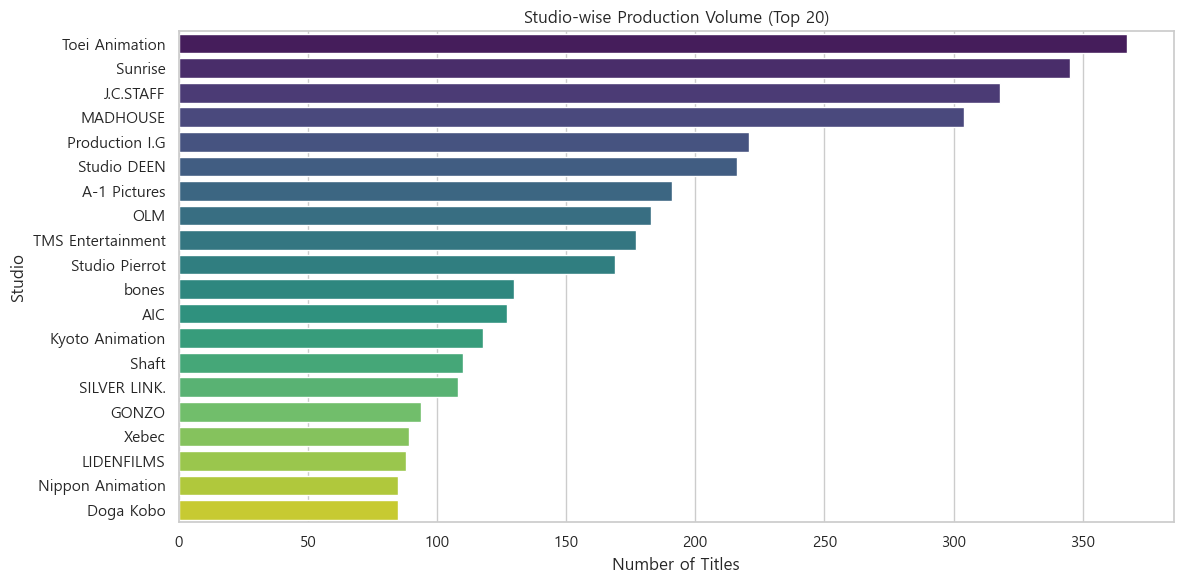

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스튜디오별 작품 수 집계
studio_counts = (
    df_eda["main_studio_name"]
    .value_counts()
    .head(20)   # 상위 20개만 시각화
)

plt.figure(figsize=(12, 6))
sns.barplot(x=studio_counts.values, y=studio_counts.index, palette="viridis")
plt.title("Studio-wise Production Volume (Top 20)")
plt.xlabel("Number of Titles")
plt.ylabel("Studio")
plt.tight_layout()
plt.show()


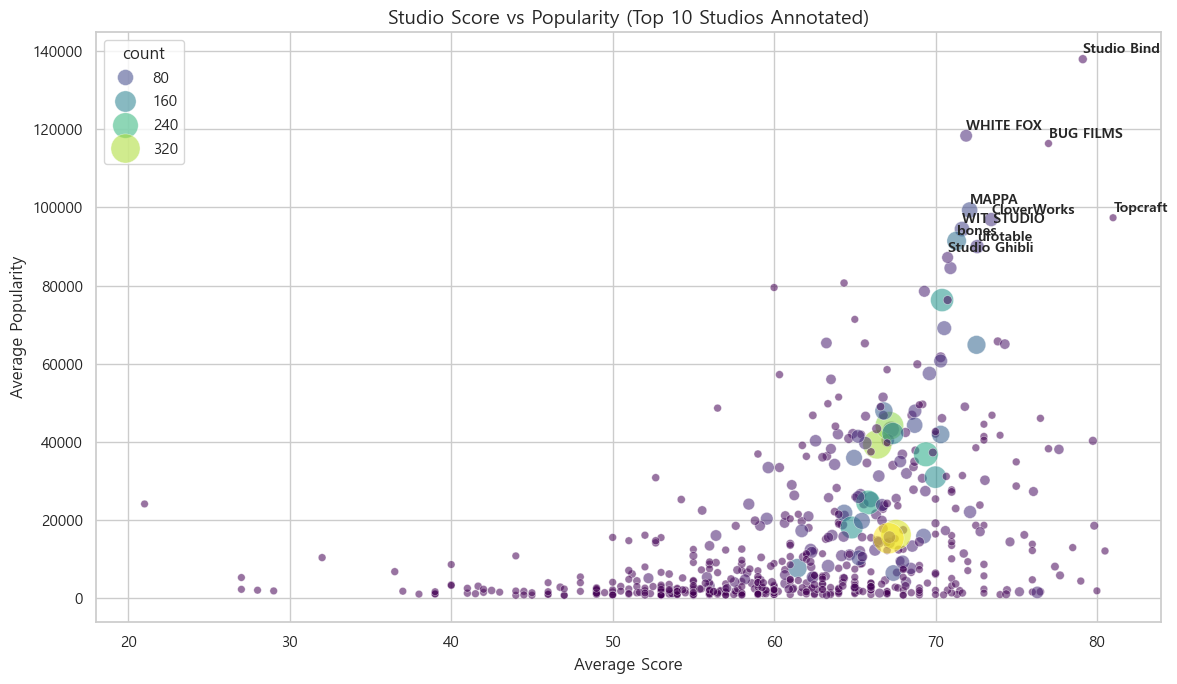

In [53]:
# 인기 기준 상위 10개 스튜디오 라벨링
top_pop_studios = studio_stats.sort_values("avg_pop", ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=studio_stats,
    x="avg_score",
    y="avg_pop",
    size="count",
    sizes=(30, 500),
    hue="count",
    palette="viridis",
    alpha=0.55
)

for _, row in top_pop_studios.iterrows():
    plt.text(row["avg_score"]+0.02, row["avg_pop"]+1500, row["main_studio_name"],
             fontsize=10, weight='bold')

plt.title("Studio Score vs Popularity (Top 10 Studios Annotated)", fontsize=14)
plt.xlabel("Average Score")
plt.ylabel("Average Popularity")
plt.tight_layout()
plt.show()


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\2664178279.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


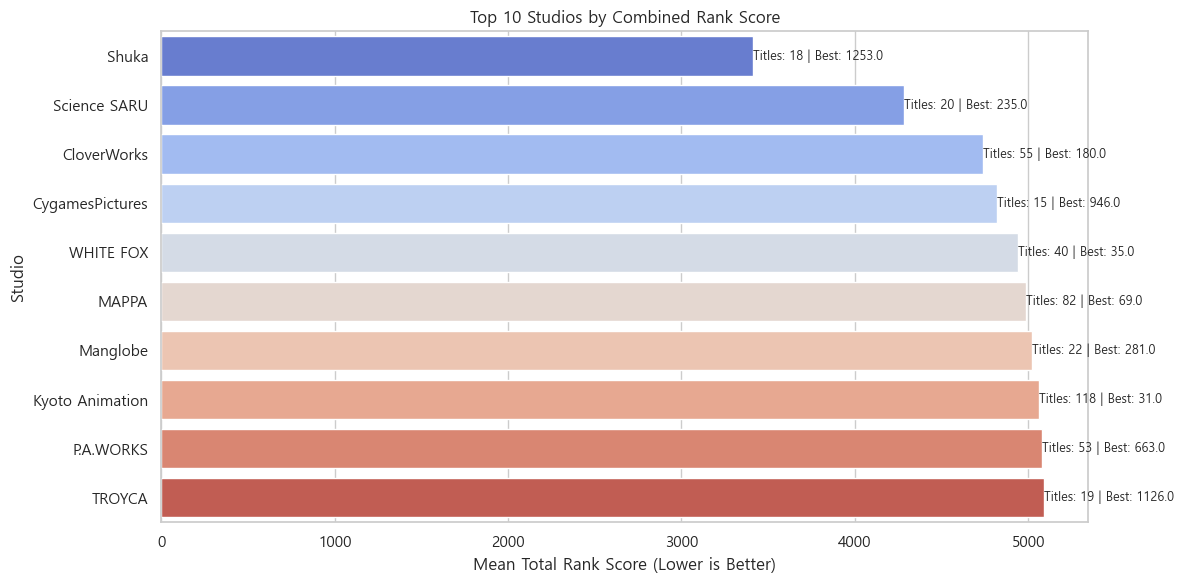

In [48]:
plot_df = top10_studios.copy()
plot_df = plot_df.sort_values("mean_total_rank", ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df,
    x="mean_total_rank",
    y="main_studio_name",
    palette="coolwarm"
)

plt.title("Top 10 Studios by Combined Rank Score")
plt.xlabel("Mean Total Rank Score (Lower is Better)")
plt.ylabel("Studio")

# 작품 수 & 대표작 주석
for i, row in plot_df.iterrows():
    plt.text(
        row["mean_total_rank"] + 0.3,
        i,
        f"Titles: {row['n_titles']} | Best: {row['best_total_rank']:.1f}",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\3106601136.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


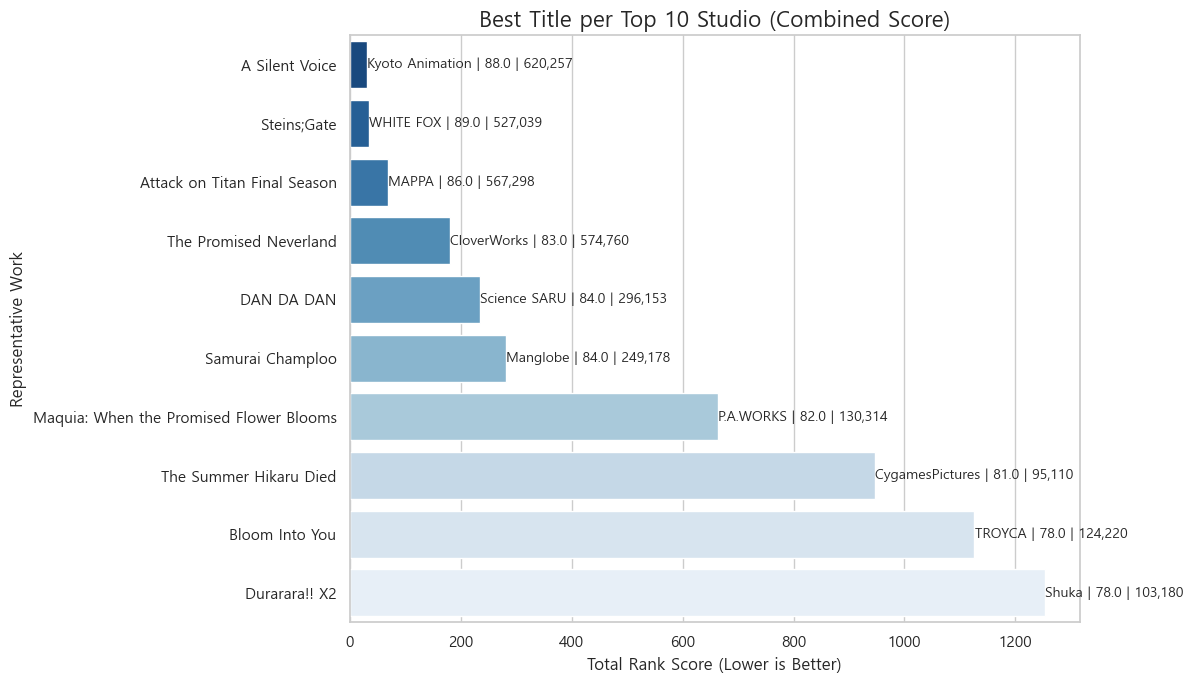

In [50]:
plot_df = best_titles_top10_studios.copy()

plt.figure(figsize=(12, 7))
sns.barplot(
    data=plot_df,
    x="total_rank_score",
    y="title_english",
    palette="Blues_r"
)

plt.title("Best Title per Top 10 Studio (Combined Score)", fontsize=16)
plt.xlabel("Total Rank Score (Lower is Better)")
plt.ylabel("Representative Work")

# 스튜디오명 + 점수 + 인기 표시
for i, row in plot_df.iterrows():
    text = f"{row['main_studio_name']} | {row['averageScore']} | {row['popularity']:,}"
    plt.text(
        row["total_rank_score"] + 0.5,
        plot_df.index.get_loc(i),
        text,
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [54]:
# Popularity Top 10
top10_pop = df_eda.sort_values("popularity", ascending=False).head(10)

# Score Top 10
top10_score = df_eda.sort_values("averageScore", ascending=False).head(10)

# Combined Top 10
df_eda["total_rank"] = df_eda["pop_rank"] + df_eda["score_rank"]
top10_combined = df_eda.sort_values("total_rank").head(10)


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\3737833800.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


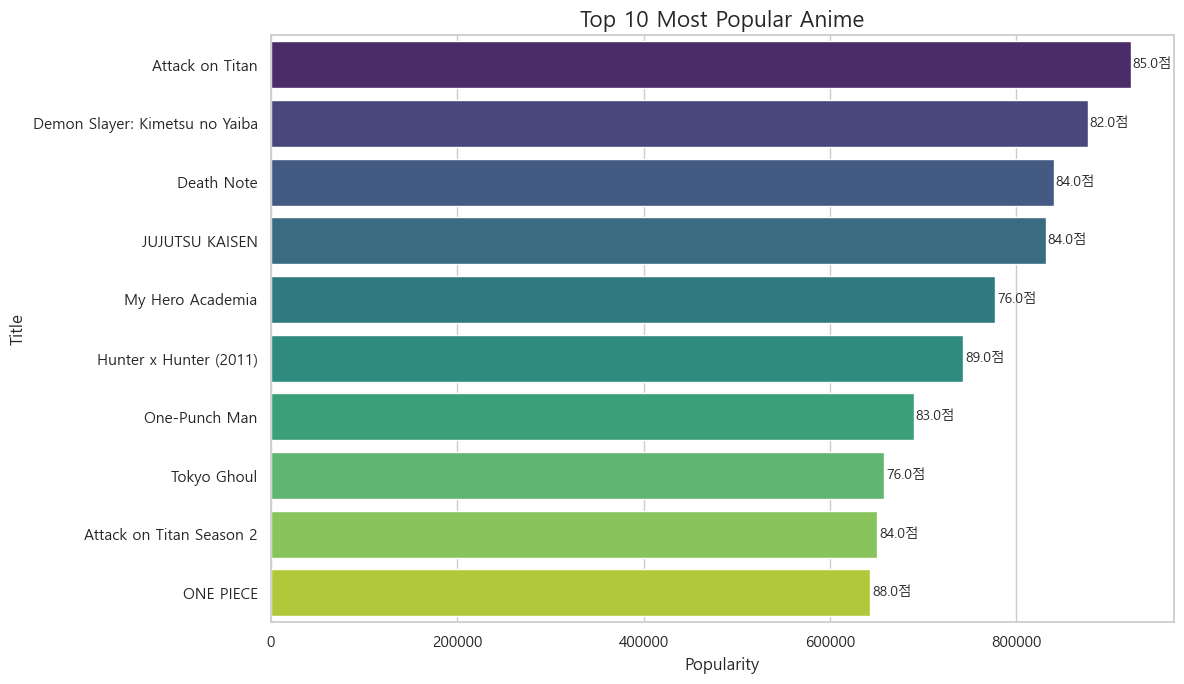

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top10_pop,
    x="popularity",
    y="title_english",
    palette="viridis"
)

plt.title("Top 10 Most Popular Anime", fontsize=16)
plt.xlabel("Popularity")
plt.ylabel("Title")

# 라벨 추가
for i, row in top10_pop.iterrows():
    plt.text(
        row["popularity"] + 2000,
        top10_pop.index.get_loc(i),
        f"{row['averageScore']}점",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\3043661385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


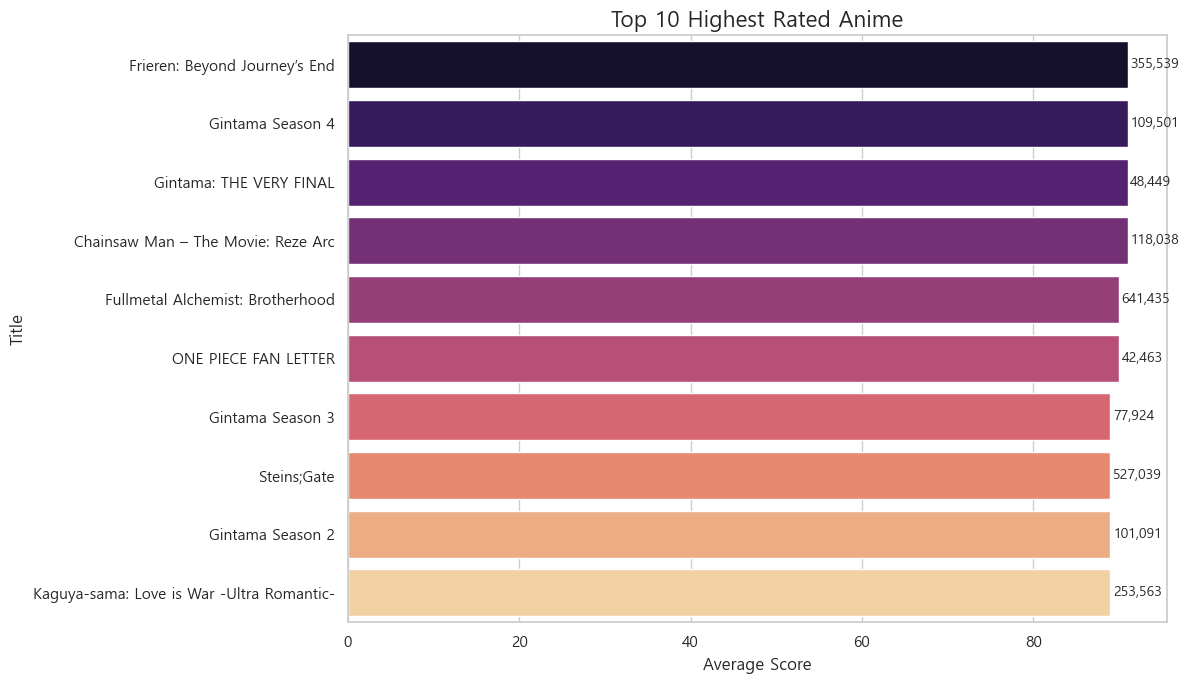

In [58]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top10_score,
    x="averageScore",
    y="title_english",
    palette="magma"
)

plt.title("Top 10 Highest Rated Anime", fontsize=16)
plt.xlabel("Average Score")
plt.ylabel("Title")

# 라벨 추가
for i, row in top10_score.iterrows():
    plt.text(
        row["averageScore"] + 0.3,
        top10_score.index.get_loc(i),
        f"{row['popularity']:,}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()


C:\Users\Playdata\AppData\Local\Temp\ipykernel_4796\3741101842.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


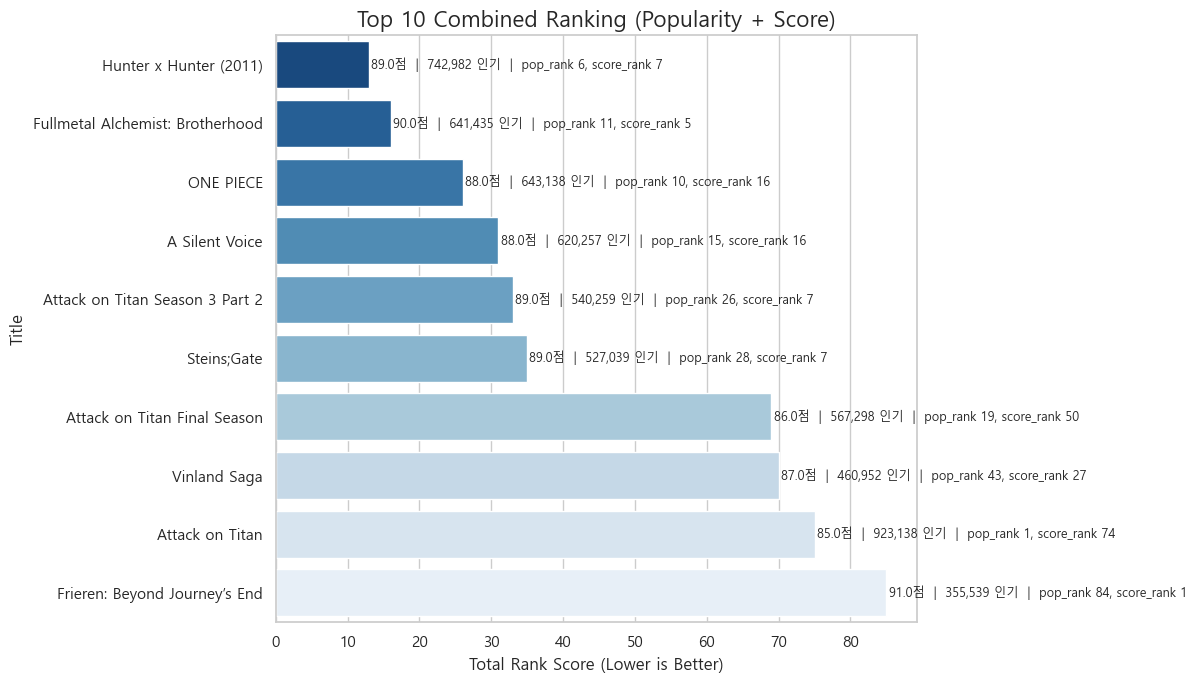

In [59]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top10_combined,
    x="total_rank",
    y="title_english",
    palette="Blues_r"
)

plt.title("Top 10 Combined Ranking (Popularity + Score)", fontsize=16)
plt.xlabel("Total Rank Score (Lower is Better)")
plt.ylabel("Title")

# 라벨 추가
for i, row in top10_combined.iterrows():
    text = (
        f"{row['averageScore']}점  |  "
        f"{row['popularity']:,} 인기  |  "
        f"pop_rank {int(row['pop_rank'])}, score_rank {int(row['score_rank'])}"
    )
    plt.text(
        row["total_rank"] + 0.3,
        top10_combined.index.get_loc(i),
        text,
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()


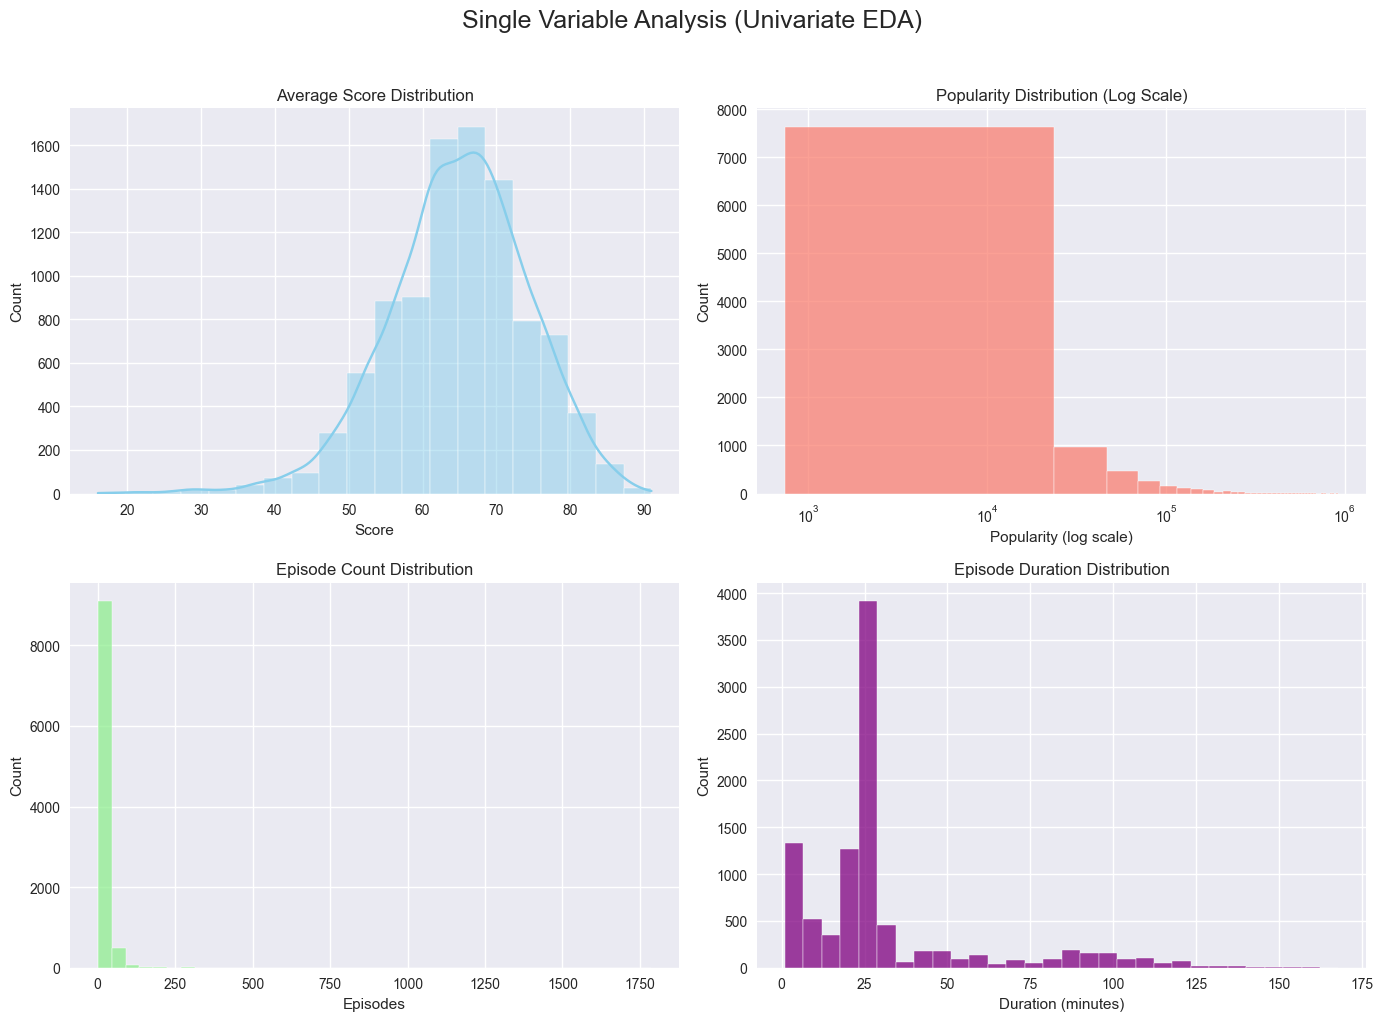

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Single Variable Analysis (Univariate EDA)", fontsize=18, y=1.02)

# ----------------------------------
# 1) Score Distribution
# ----------------------------------
sns.histplot(
    data=df_eda, 
    x="averageScore", 
    kde=True, 
    bins=20,
    color="skyblue",
    ax=axes[0, 0]
)
axes[0, 0].set_title("Average Score Distribution")
axes[0, 0].set_xlabel("Score")
axes[0, 0].set_ylabel("Count")

# ----------------------------------
# 2) Popularity (Long-tail) Distribution
#    로그스케일 사용 → 구조가 잘 드러남
# ----------------------------------
sns.histplot(
    data=df_eda,
    x="popularity",
    bins=40,
    color="salmon",
    ax=axes[0, 1]
)
axes[0, 1].set_xscale("log")
axes[0, 1].set_title("Popularity Distribution (Log Scale)")
axes[0, 1].set_xlabel("Popularity (log scale)")
axes[0, 1].set_ylabel("Count")

# ----------------------------------
# 3) Episodes Distribution
# ----------------------------------
sns.histplot(
    data=df_eda,
    x="episodes",
    bins=40,
    color="lightgreen",
    ax=axes[1, 0]
)
axes[1, 0].set_title("Episode Count Distribution")
axes[1, 0].set_xlabel("Episodes")
axes[1, 0].set_ylabel("Count")

# ----------------------------------
# 4) Duration Distribution
# ----------------------------------
sns.histplot(
    data=df_eda,
    x="duration",
    bins=30,
    color="purple",
    ax=axes[1, 1]
)
axes[1, 1].set_title("Episode Duration Distribution")
axes[1, 1].set_xlabel("Duration (minutes)")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()
